# File Overview

The swin2sr_div2k_finetuning.ipynb notebook documents and completes the full[link text](https://) process of taking the pretrained Swin2SR ×4 super resolution model from Hugging Face and lightly fine tuning it on a subset of the DIV2K dataset using an A100‑80GB GPU in Colab. It walks through setting up the environment, preparing LR/HR image pairs, defining a custom PyTorch training loop over random patches, saving the fine tuned checkpoint, and visualizing both qualitative results and a short loss curve.

In [ ]:
# Fine Tune Swin SR Model

### GPU Setup and Dependencies

In [ ]:
!nvidia-smi


Fri Dec  5 08:04:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             54W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!pip install -q "transformers>=4.40.0" accelerate torch torchvision pillow


### Download and Unzip DIV2K Data

In [ ]:
%cd /content

# HR images
!wget -q https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget -q https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

# Bicubic x4 LR images
!wget -q https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
!wget -q https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip

!unzip -q DIV2K_train_HR.zip -d DIV2K
!unzip -q DIV2K_valid_HR.zip -d DIV2K
!unzip -q DIV2K_train_LR_bicubic_X4.zip -d DIV2K
!unzip -q DIV2K_valid_LR_bicubic_X4.zip -d DIV2K

!ls DIV2K


/content
DIV2K_train_HR	DIV2K_train_LR_bicubic	DIV2K_valid_HR	DIV2K_valid_LR_bicubic


### DIV2K PyTorch Dataset Definition

In [ ]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch

class DIV2KDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, max_images=None):
        self.lr_paths = sorted(list(Path(lr_dir).glob("*.png")))
        if max_images is not None:
            self.lr_paths = self.lr_paths[:max_images]
        self.hr_dir = Path(hr_dir)

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr_path = self.lr_paths[idx]
        hr_path = self.hr_dir / lr_path.name.replace("x4", "")  # filenames ---- 0001x4.png
        lr = Image.open(lr_path).convert("RGB")
        hr = Image.open(hr_path).convert("RGB")
        return lr, hr

train_lr_dir = "/content/DIV2K/DIV2K_train_LR_bicubic/X4"
train_hr_dir = "/content/DIV2K/DIV2K_train_HR"

train_ds = DIV2KDataset(train_lr_dir, train_hr_dir, max_images=200)  # limit for speed
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

len(train_ds)


200

### Load Pretrained Swin2SR Model

In [ ]:
from transformers import AutoImageProcessor, Swin2SRForImageSuperResolution

MODEL_ID = "caidas/swin2SR-realworld-sr-x4-64-bsrgan-psnr"

processor = AutoImageProcessor.from_pretrained(MODEL_ID)
model = Swin2SRForImageSuperResolution.from_pretrained(MODEL_ID)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`self.pad_size` attribute is deprecated and will be removed in v5. Use `self.size_divisor` instead


config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/48.5M [00:00<?, ?B/s]

Swin2SRForImageSuperResolution(
  (swin2sr): Swin2SRModel(
    (first_convolution): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (embeddings): Swin2SREmbeddings(
      (patch_embeddings): Swin2SRPatchEmbeddings(
        (projection): Conv2d(180, 180, kernel_size=(1, 1), stride=(1, 1))
        (layernorm): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swin2SREncoder(
      (stages): ModuleList(
        (0-5): 6 x Swin2SRStage(
          (layers): ModuleList(
            (0-5): 6 x Swin2SRLayer(
              (attention): Swin2SRAttention(
                (self): Swin2SRSelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=6, bias=False)
                  )
                  (que

In [ ]:
#torch.cuda.empty_cache()

### Fine Tuning Loops

In [ ]:
import torch
import random

optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
loss_fn = torch.nn.L1Loss()

patch_size_lr = 32       # super small LR patch
scale = 4
patch_size_hr = patch_size_lr * scale

num_steps = 50           # just to demonstrate fine-tuning
step = 0

model.train()
torch.cuda.empty_cache()

for epoch in range(1):   # single epoch over subset
    for i in range(len(train_ds)):
        if step >= num_steps:
            break

        lr_img, hr_img = train_ds[i]

        w, h = lr_img.size
        if w < patch_size_lr or h < patch_size_lr:
            continue

        x = random.randint(0, w - patch_size_lr)
        y = random.randint(0, h - patch_size_lr)

        lr_crop = lr_img.crop((x, y, x + patch_size_lr, y + patch_size_lr))
        hr_crop = hr_img.crop(
            (x * scale, y * scale, (x + patch_size_lr) * scale, (y + patch_size_lr) * scale)
        )

        inputs = processor(images=[lr_crop], return_tensors="pt").to(device)
        target_batch = processor(images=[hr_crop], return_tensors="pt").to(device)
        targets = target_batch["pixel_values"]

        outputs = model(**inputs)
        sr = outputs.reconstruction

        if sr.shape[-2:] != targets.shape[-2:]:
            _, _, h_t, w_t = targets.shape
            sr = torch.nn.functional.interpolate(
                sr, size=(h_t, w_t), mode="bilinear", align_corners=False
            )

        loss = loss_fn(sr, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            print(f"step {step}  loss {loss.item():.4f}")
        step += 1

    if step >= num_steps:
        break


step 0  loss 0.0776
step 10  loss 0.1535
step 20  loss 0.0057
step 30  loss 0.0938
step 40  loss 0.1171


In [ ]:
save_dir = "/content/swin2sr_div2k_finetuned"
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

!ls "$save_dir"


config.json  model.safetensors	preprocessor_config.json


In [ ]:
from google.colab import files
!zip -qr swin2sr_div2k_finetuned.zip swin2sr_div2k_finetuned
files.download("swin2sr_div2k_finetuned.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# more intense fine tune now we got a100

import torch
import random

optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
loss_fn = torch.nn.L1Loss()

patch_size_lr = 64       # LR patch (256×256 HR)
scale = 4
patch_size_hr = patch_size_lr * scale

num_steps = 1000         # more serious fine tune
step = 0

model.train()
torch.cuda.empty_cache()

for epoch in range(5):   # up to 5 passes over subset
    for i in range(len(train_ds)):
        if step >= num_steps:
            break

        lr_img, hr_img = train_ds[i]

        w, h = lr_img.size
        if w < patch_size_lr or h < patch_size_lr:
            continue

        # random aligned crop
        x = random.randint(0, w - patch_size_lr)
        y = random.randint(0, h - patch_size_lr)

        lr_crop = lr_img.crop((x, y, x + patch_size_lr, y + patch_size_lr))
        hr_crop = hr_img.crop(
            (x * scale, y * scale,
             (x + patch_size_lr) * scale, (y + patch_size_lr) * scale)
        )

        inputs = processor(images=[lr_crop], return_tensors="pt").to(device)
        target_batch = processor(images=[hr_crop], return_tensors="pt").to(device)
        targets = target_batch["pixel_values"]  # (1, C, H, W)

        with torch.cuda.amp.autocast(enabled=True):
            outputs = model(**inputs)
            sr = outputs.reconstruction

            if sr.shape[-2:] != targets.shape[-2:]:
                _, _, h_t, w_t = targets.shape
                sr = torch.nn.functional.interpolate(
                    sr, size=(h_t, w_t),
                    mode="bilinear", align_corners=False
                )

            loss = loss_fn(sr, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"step {step}  loss {loss.item():.4f}")
        step += 1

    if step >= num_steps:
        break

print("Finished fine-tuning, total steps:", step)


/tmp/ipython-input-3264579614.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


step 0  loss 0.0939
step 50  loss 0.0881
step 100  loss 0.1467
step 150  loss 0.0870
step 200  loss 0.0745
step 250  loss 0.1039
step 300  loss 0.0032
step 350  loss 0.0137
step 400  loss 0.0706
step 450  loss 0.1174
step 500  loss 0.0032
step 550  loss 0.1538
step 600  loss 0.0669
step 650  loss 0.1465
step 700  loss 0.1141
step 750  loss 0.1414
step 800  loss 0.0947
step 850  loss 0.0857
step 900  loss 0.0721
step 950  loss 0.1357
Finished fine-tuning, total steps: 1000


In [ ]:
save_dir = "/content/swin2sr_div2k_finetuned_x4_1000steps"
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)


['/content/swin2sr_div2k_finetuned_x4_1000steps/preprocessor_config.json']

In [ ]:
from google.colab import files
!zip -qr swin2sr_div2k_finetuned_x4_1000steps.zip swin2sr_div2k_finetuned_x4_1000steps
files.download("swin2sr_div2k_finetuned_x4_1000steps.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Qualitative Comparisons

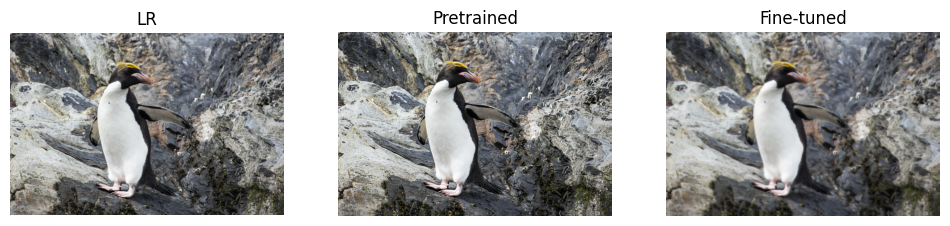

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

test_lr = Image.open("/content/DIV2K/DIV2K_valid_LR_bicubic/X4/0801x4.png").convert("RGB")
inputs = processor(images=[test_lr], return_tensors="pt").to(device)

with torch.no_grad():
    out_base = Swin2SRForImageSuperResolution.from_pretrained(
        "caidas/swin2SR-realworld-sr-x4-64-bsrgan-psnr"
    ).to(device)(**inputs).reconstruction.clamp(0, 1)
    out_ft = model(**inputs).reconstruction.clamp(0, 1)

sr_base = out_base[0].cpu().permute(1, 2, 0).numpy()
sr_ft = out_ft[0].cpu().permute(1, 2, 0).numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(test_lr); plt.title("LR"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(sr_base); plt.title("Pretrained"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(sr_ft); plt.title("Fine-tuned"); plt.axis("off")
plt.show()



=== Image 0801 ===


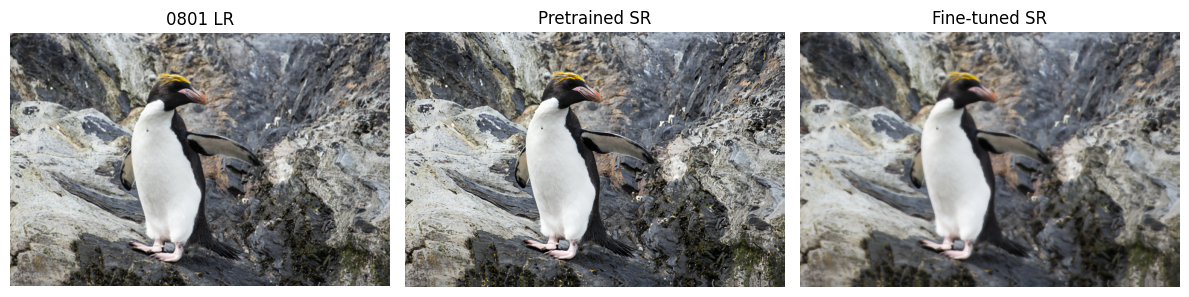

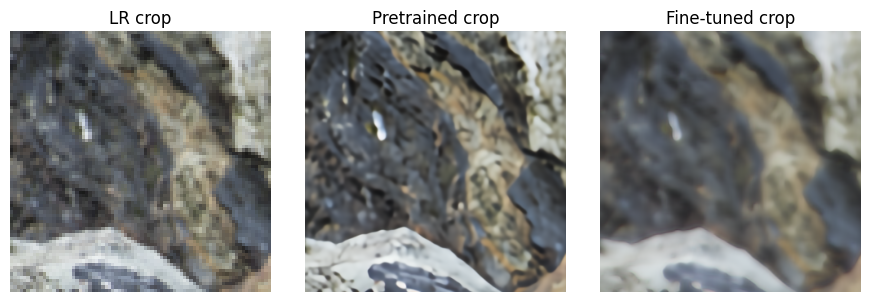


=== Image 0802 ===


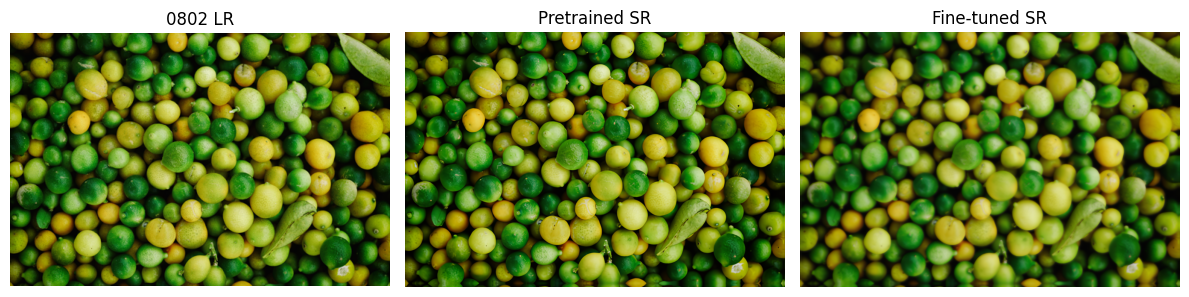

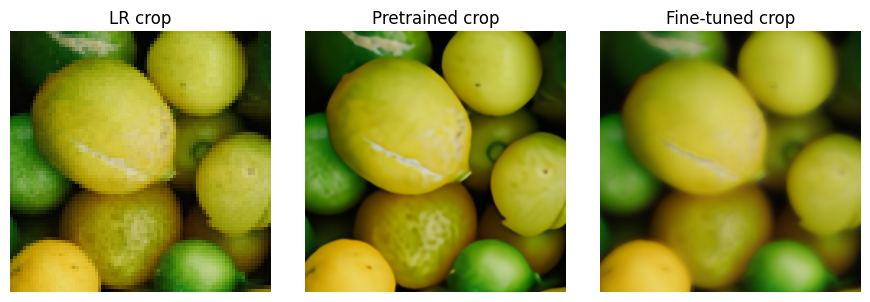


=== Image 0803 ===


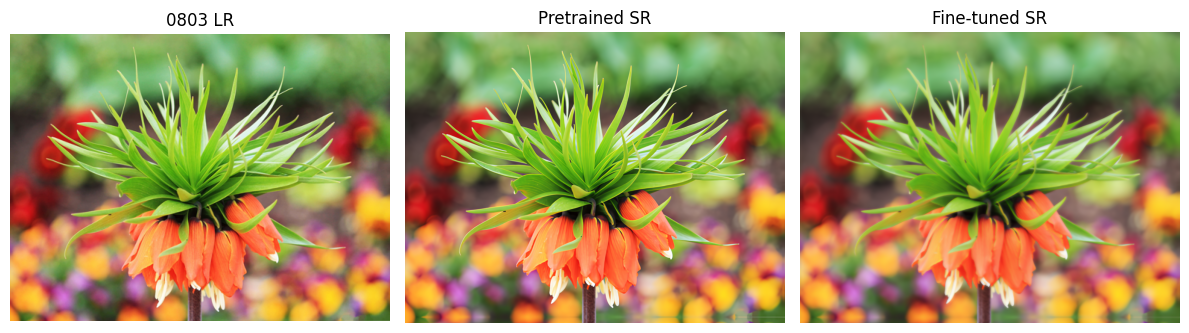

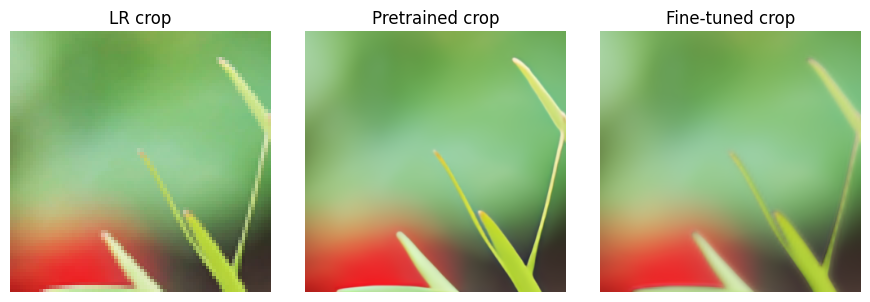

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import Swin2SRForImageSuperResolution

# Pretrained baseline model (loaded once)
base_model = Swin2SRForImageSuperResolution.from_pretrained(
    "caidas/swin2SR-realworld-sr-x4-64-bsrgan-psnr"
).to(device)
base_model.eval()
model.eval()

# Choose three validation LR images (can change indices)
indices = ["0801", "0802", "0803"]

# Common crop in LR coordinates (tweak if needed)
# (y1:y2, x1:x2)
y1, y2 = 40, 120
x1, x2 = 80, 160
scale = 4

for idx in indices:
    print(f"\n=== Image {idx} ===")

    # Load LR image
    lr_path = f"/content/DIV2K/DIV2K_valid_LR_bicubic/X4/{idx}x4.png"
    test_lr = Image.open(lr_path).convert("RGB")

    # Prepare input
    inputs = processor(images=[test_lr], return_tensors="pt").to(device)

    with torch.no_grad():
        out_base = base_model(**inputs).reconstruction.clamp(0, 1)
        out_ft   = model(**inputs).reconstruction.clamp(0, 1)

    # To numpy
    lr_np    = np.array(test_lr)
    sr_base  = out_base[0].cpu().permute(1, 2, 0).numpy()
    sr_ft    = out_ft[0].cpu().permute(1, 2, 0).numpy()

    # Full size comparison
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(lr_np);   plt.title(f"{idx} LR");         plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(sr_base); plt.title("Pretrained SR");     plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(sr_ft);   plt.title("Fine-tuned SR");     plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Zoomed crop
    lr_head = lr_np[y1:y2, x1:x2]

    Hy1, Hy2 = y1 * scale, y2 * scale
    Hx1, Hx2 = x1 * scale, x2 * scale
    base_head = sr_base[Hy1:Hy2, Hx1:Hx2]
    ft_head   = sr_ft[Hy1:Hy2, Hx1:Hx2]

    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1); plt.imshow(lr_head);   plt.title("LR crop");         plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(base_head); plt.title("Pretrained crop"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(ft_head);   plt.title("Fine-tuned crop"); plt.axis("off")
    plt.tight_layout()
    plt.show()


### Logging and Plotting Training Loss

In [ ]:
import torch
import random

loss_history = []

num_steps = 300   # smaller number is just for a curve
step = 0

model.train()
torch.cuda.empty_cache()

patch_size_lr = 64
scale = 4

for epoch in range(5):
    for i in range(len(train_ds)):
        if step >= num_steps:
            break

        # ----- patch sampling -----
        lr_img, hr_img = train_ds[i]

        w, h = lr_img.size
        if w < patch_size_lr or h < patch_size_lr:
            continue

        x = random.randint(0, w - patch_size_lr)
        y = random.randint(0, h - patch_size_lr)

        lr_crop = lr_img.crop((x, y, x + patch_size_lr, y + patch_size_lr))
        hr_crop = hr_img.crop(
            (x * scale, y * scale,
             (x + patch_size_lr) * scale, (y + patch_size_lr) * scale)
        )

        inputs = processor(images=[lr_crop], return_tensors="pt").to(device)
        target_batch = processor(images=[hr_crop], return_tensors="pt").to(device)
        targets = target_batch["pixel_values"]

        # ----- forward & loss -----
        with torch.cuda.amp.autocast(enabled=True):
            outputs = model(**inputs)
            sr = outputs.reconstruction

            if sr.shape[-2:] != targets.shape[-2:]:
                _, _, h_t, w_t = targets.shape
                sr = torch.nn.functional.interpolate(
                    sr, size=(h_t, w_t), mode="bilinear", align_corners=False
                )

            loss = loss_fn(sr, targets)

        # ----- backward -----
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if step % 20 == 0:
            print(f"step {step}  loss {loss.item():.4f}")
        step += 1

    if step >= num_steps:
        break

print("Finished:", step, "steps")


/tmp/ipython-input-388936115.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


step 0  loss 0.1006
step 20  loss 0.0989
step 40  loss 0.0137
step 60  loss 0.0932
step 80  loss 0.1094
step 100  loss 0.1014
step 120  loss 0.0444
step 140  loss 0.1347
step 160  loss 0.0838
step 180  loss 0.0733
step 200  loss 0.0780
step 220  loss 0.1280
step 240  loss 0.2141
step 260  loss 0.0586
step 280  loss 0.0520
Finished: 300 steps


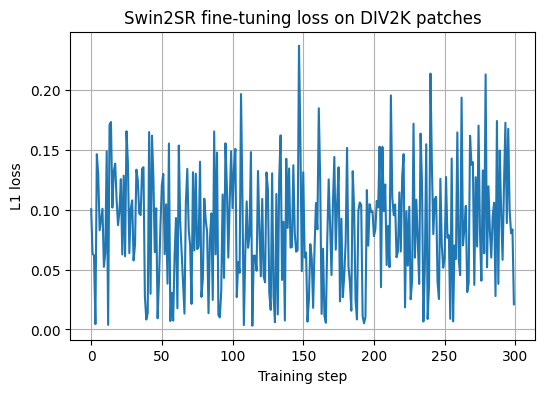

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel("Training step")
plt.ylabel("L1 loss")
plt.title("Swin2SR fine-tuning loss on DIV2K patches")
plt.grid(True)
plt.show()


In [ ]:
'''
The plot shows how the L1 reconstruction loss changed during an additional 300 step fine tuning run on random DIV2K patches.
Earlier in the notebook the model was already fine tuned, but the losses from that run were not logged or saved,
so another shorter loop with 300 steps was run specifically to capture this "curve".

Each point on the graph corresponds to one optimization step, measuring the absolute difference between the model’s
super resolved patch and the corresponding high resolution ground truth patch. Because every step uses a different random crop,
some patches are easier and some are harder, so the loss values bounce around between roughly 0 and 0.22 instead of forming a
perfectly smooth line. Overall, the loss fluctuates around about 0.1 without a strong downward trend, which is reasonable given
that Swin2SR started from a heavily pretrained checkpoint and this extra 300‑step run only makes small adjustments rather than
dramatically improving training error.

'''

In [ ]:
'''
.
END OF DOC

.
.

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
..
.
.
.

.
.
.
.
.
.
.
..
.
.
.
.
.
.
.

'''

